# Neural style transfer

### Import and configure modules

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/Style Transfer/')

Mounted at /content/drive


In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Specify path to the style image and the content image:

In [5]:
content_path = './Rocks.jpg'
style_path = './Van Gogh - The Starry Night.jpg'
result_dir = content_path[2:-4] + ' + ' + style_path[2:-4]

try:
    os.mkdir(result_dir)
except:
    pass

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  print('Initial Image Shape', img.shape)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  print('Final Shape after Reshaping', new_shape, '\n')

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Initial Image Shape (384, 256, 3)
Final Shape after Reshaping tf.Tensor([512 341], shape=(2,), dtype=int32) 

Initial Image Shape (899, 1135, 3)
Final Shape after Reshaping tf.Tensor([405 512], shape=(2,), dtype=int32) 



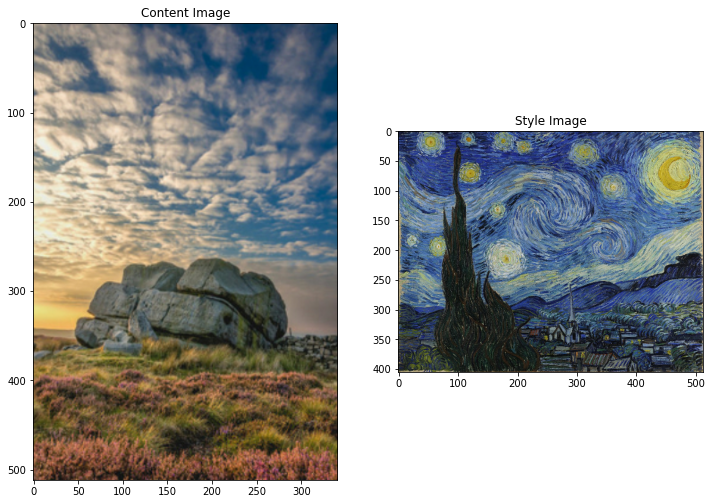

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Now load a `VGG19` without the classification head, and list the layer names

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [11]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  # print(model.summary())
  return model

And to create the model:

In [12]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  677.1133
  mean:  24.216642

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  3036.2969
  mean:  150.2303

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7388.543
  mean:  144.96101

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  17374.877
  mean:  570.7881

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4069.529
  mean:  49.110382



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  print(input_shape)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  print(num_locations)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [14]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [15]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


tf.Tensor([  1 512 341  64], shape=(4,), dtype=int32)
tf.Tensor(174592.0, shape=(), dtype=float32)
tf.Tensor([  1 256 170 128], shape=(4,), dtype=int32)
tf.Tensor(43520.0, shape=(), dtype=float32)
tf.Tensor([  1 128  85 256], shape=(4,), dtype=int32)
tf.Tensor(10880.0, shape=(), dtype=float32)
tf.Tensor([  1  64  42 512], shape=(4,), dtype=int32)
tf.Tensor(2688.0, shape=(), dtype=float32)
tf.Tensor([  1  32  21 512], shape=(4,), dtype=int32)
tf.Tensor(672.0, shape=(), dtype=float32)
Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.018785745
    max:  12800.125
    mean:  304.9449

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  70199.32
    mean:  9658.59

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.07659822
    max:  442010.97
    mean:  9919.384

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4608988.0
    mean:  125397.266

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  51411.51
    mean:  660.4122

Content

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [16]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

tf.Tensor([  1 405 512  64], shape=(4,), dtype=int32)
tf.Tensor(207360.0, shape=(), dtype=float32)
tf.Tensor([  1 202 256 128], shape=(4,), dtype=int32)
tf.Tensor(51712.0, shape=(), dtype=float32)
tf.Tensor([  1 101 128 256], shape=(4,), dtype=int32)
tf.Tensor(12928.0, shape=(), dtype=float32)
tf.Tensor([  1  50  64 512], shape=(4,), dtype=int32)
tf.Tensor(3200.0, shape=(), dtype=float32)
tf.Tensor([  1  25  32 512], shape=(4,), dtype=int32)
tf.Tensor(800.0, shape=(), dtype=float32)
tf.Tensor([  1 512 341  64], shape=(4,), dtype=int32)
tf.Tensor(174592.0, shape=(), dtype=float32)
tf.Tensor([  1 256 170 128], shape=(4,), dtype=int32)
tf.Tensor(43520.0, shape=(), dtype=float32)
tf.Tensor([  1 128  85 256], shape=(4,), dtype=int32)
tf.Tensor(10880.0, shape=(), dtype=float32)
tf.Tensor([  1  64  42 512], shape=(4,), dtype=int32)
tf.Tensor(2688.0, shape=(), dtype=float32)
tf.Tensor([  1  32  21 512], shape=(4,), dtype=int32)
tf.Tensor(672.0, shape=(), dtype=float32)


Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [17]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [18]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [20]:
style_weight=1e-2
content_weight=1e4

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [22]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

### Run the optimization and save the resultant image

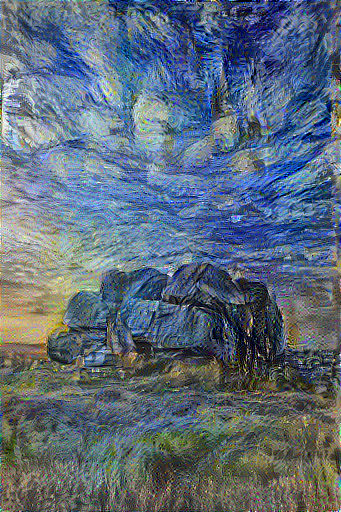

Train step: 1500
Total time: 107.0


In [ ]:
import time
start = time.time()

epochs = 15
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  file_dir = './' + result_dir + '/' + content_path[2:-4] + ' + ' + style_path[2:-4] + ' ' + str(n+1) + '.png'
  tensor_to_image(image).save(file_dir)
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))